In [1]:
from implicit_filter import JaxFilter, make_tri
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

# Create mesh

### Define mesh parameters

In [2]:
# ============
# Mesh size:
# ============
Lx = 1000
Ly = Lx
# ===========
# Cell size and x,y vectors
# ===========
dxm = 1
dym = dxm
cyclic = 0  # 1 if mesh is cyclic
cyclic_length = 360  # in degrees; if not cyclic, take it larger than  zonal size
cyclic_length = cyclic_length * math.pi / 180  # DO NOT TOUCH
meshtype = 'm'  # coordinates can be in physical measure 'm' or in radians 'r'
cartesian = False
r_earth = 6400

### Create mesh

In [3]:
xx = np.arange(0, Lx + 1, dxm)
yy = np.arange(0, Ly + 1, dym)

nx = len(xx)
ny = len(yy)
# =============
# 2D regular array of points,
# their x and y coordinates.
# We will create triangles later
# =============

nodnum = np.arange(0, nx * ny)
xcoord = np.zeros((ny, nx))
ycoord = xcoord.copy()

for i in range(nx):
    ycoord[i, :] = yy

for i in range(ny):
    xcoord[:, i] = xx

### Create synthetic data

In [4]:
tt = 50 * (np.random.random(xcoord.shape) - 0.5)
ttf = np.fft.fft2(tt)
# ============
# Make spectrum red
# ============
espectrum = np.zeros((nx // 2 + 1))  # Place for Fourier spectrum
kk = np.concatenate((np.arange(0, nx // 2 + 1), np.arange(-nx // 2 + 1, 0, 1)))  # Wavenumbers

for mx in range(nx):
    for my in range(ny):
        ll = np.sqrt(kk[my] * kk[my] + kk[mx] * kk[mx])  # Absolute value
        if my == 0 and mx == 0:  # Remove area mean
            ttf[my, mx] = 0.0
        else:  # Adjust amplitudes
            tmp = ttf[my, mx] / (np.power(ll, 1.5))  # 1.5 for -2 spectrum
            ttf[my, mx] = tmp
        if ll + 1 <= nx // 2 + 1:
            espectrum[np.floor(ll).astype(int)] += ttf[my, mx] * np.conj(ttf[my, mx])

espectrum = espectrum / np.power(nx, 4)

tt = np.real(np.fft.ifft2(ttf))  # We expect that it will show - 2 spectrum

/var/folders/p7/__mkfjf91fd70x4d4rzgvsq0rx9_k9/T/ipykernel_16923/2588423314.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  espectrum[np.floor(ll).astype(int)] += ttf[my, mx] * np.conj(ttf[my, mx])


### Reshape arrays and create triangulation

In [5]:
nodnum = np.reshape(nodnum, [ny, nx]).T
xcoord = np.reshape(xcoord, [nx * ny])
ycoord = np.reshape(ycoord, [nx * ny])
tt = np.reshape(tt, [nx * ny])

In [6]:
tri = make_tri(nodnum, nx, ny)
n2d = len(xcoord)  # The number of vertices(nodes)
e2d = len(tri[:, 1])

# Filtering

### Define wavelengths

In [7]:
Kc = np.array([2, 2.2, 2.5, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 30, 40, 60, 80, 100, 200]) * dxm
Kc = 2 * math.pi / Kc  # Wavenumbers
nr = len(Kc)

### Prepare filter

In [8]:
jf = JaxFilter()
jf.prepare(n2d, e2d, tri, xcoord, ycoord, meshtype, cartesian, cyclic_length)

### Filter

#### Single case

In [9]:
%%time
tts = jf.compute(1, Kc[-1], tt)

CPU times: user 20.3 s, sys: 17.1 s, total: 37.5 s
Wall time: 3.47 s


#### Before

In [10]:
triang = mpl.tri.Triangulation(xcoord, ycoord, tri)

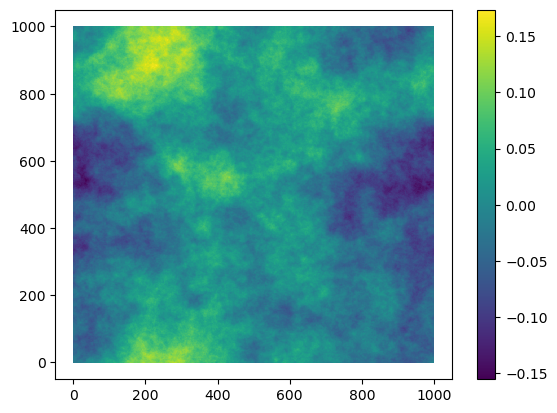

In [11]:
plt.tripcolor(triang, tt)
plt.colorbar()

#### After

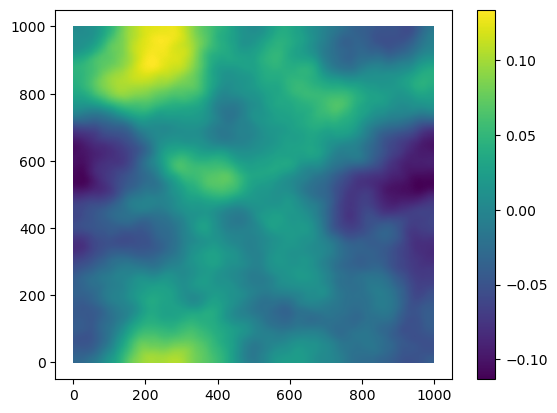

In [12]:
plt.tripcolor(triang, tts)
plt.colorbar()

### Cumulative spectrum through coarse graining

In [13]:
spectra = np.zeros(nr)

In [16]:
%%time
for i in range(nr):
    tts = jf.compute(1, Kc[i], tt)
    spectra[i] = np.sum(np.square(tts)) # We assume that all triangles have the same area

CPU times: user 1min 39s, sys: 2min 20s, total: 4min
Wall time: 22.9 s


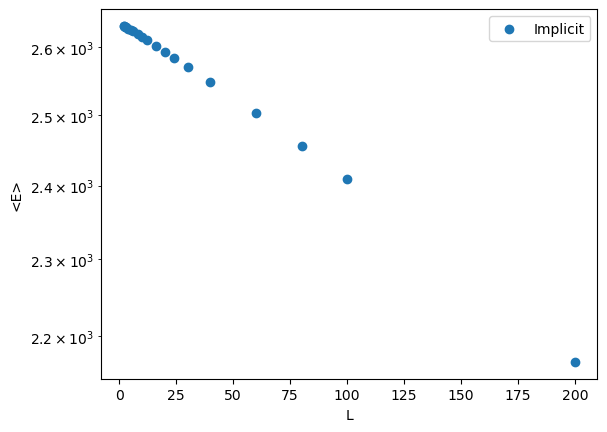

In [17]:
plt.scatter((2*math.pi/Kc), spectra, label="Implicit")
plt.xlabel("L")
plt.ylabel("<E>")
plt.legend()
plt.yscale("log")